# Analysis of Air Quality Index in Delhi

### Objective

##### 1. To find the distribution of pollutants
##### 2. To calculate AQI
##### 3. See how often different air quality conditions occur.
##### 4. Look at how air quality changes throughout the day to find the busiest pollution times.
##### 5. Check if certain pollutants tend to rise or fall together, showing how they're connected.
##### 6. To utilize time series analysis using the Facebook Prophet method to forecast air quality trends and patterns over time.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Importing Dataset

In [2]:
data = pd.read_csv('delhiaqi.csv')

In [3]:
data

,date,co,no,no2,o3,so2,pm2_5,pm10,nh3
0,2023-01-01 00:00:00,1655.58,1.66,39.41,5.90,17.88,169.29,194.64,5.83
1,2023-01-01 01:00:00,1869.20,6.82,42.16,1.99,22.17,182.84,211.08,7.66
2,2023-01-01 02:00:00,2510.07,27.72,43.87,0.02,30.04,220.25,260.68,11.40
3,2023-01-01 03:00:00,3150.94,55.43,44.55,0.85,35.76,252.90,304.12,13.55
4,2023-01-01 04:00:00,3471.37,68.84,45.24,5.45,39.10,266.36,322.80,14.19
...,...,...,...,...,...,...,...,...,...
556,2023-01-24 04:00:00,1762.39,4.64,37.01,33.26,30.52,231.15,289.84,6.27
557,2023-01-24 05:00:00,1735.69,6.82,34.96,46.49,34.33,225.08,280.52,9.12
558,2023-01-24 06:00:00,1922.61,8.16,40.10,56.51,43.39,242.49,296.07,12.54
559,2023-01-24 07:00:00,1361.85,9.05,52.78,71.53,100.14,165.67,191.82,7.47


### Data Distribution of Pollutants

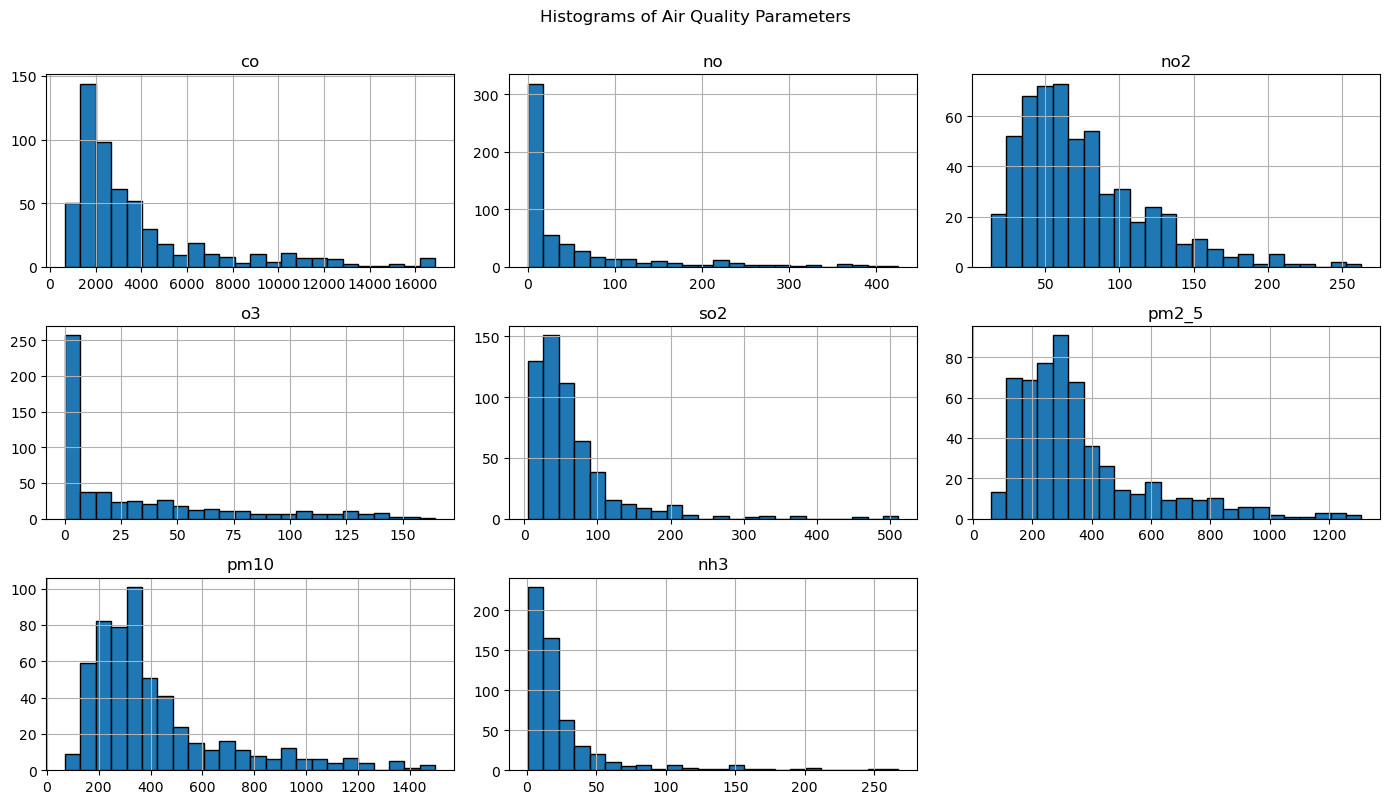

In [4]:
features = data.drop(columns = ['date'])
features.hist(bins= 24, figsize=(14,8), edgecolor = 'black')
plt.suptitle('Histograms of Air Quality Parameters', y = 1)
plt.tight_layout()
sns.set_palette('Set2')
plt.show()

In [5]:
values = data[['co','no','no2','o3','so2','pm2_5','pm10','nh3']].sum(axis=0)
pollutants = list(['co','no','no2','o3','so2','pm2_5','pm10','nh3'])

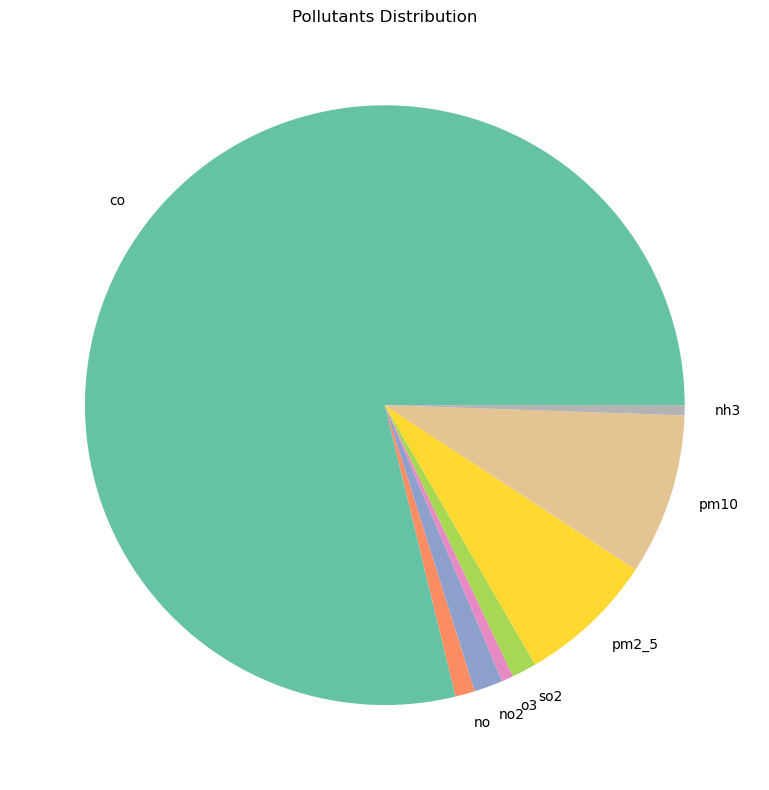

In [6]:
sns.set_palette('Set2')
plt.figure(figsize =(12,8))
plt.pie(values, labels = pollutants)
plt.title('Pollutants Distribution')
plt.tight_layout()

#### Carbon Monoxide (CO) makes up the biggest part of the pollution, about 69%.

## Air Quality Index

In [7]:
co_breakpoints = [(0, 1, 0, 50), (1.01, 2, 51, 100), (2.01, 10, 101, 200),
(10.01, 17, 201, 300), (17.01, 34, 301, 400), (34.01, 999999, 401, 500)]

no2_breakpoints = [(0, 40, 0, 50), (41, 80, 51, 100), (81, 180, 101, 200),
(181, 280, 201, 300), (281, 400, 301, 400), (401, 999999, 401, 500)]

no_breakpoints = no2_breakpoints

o3_breakpoints = [(0, 50, 0, 50), (51, 100, 51, 100), (101, 168, 101, 200),
(169, 208, 201, 300), (209, 748, 301, 400), (749, 999999, 401, 500)]

so2_breakpoints = [(0, 40, 0, 50), (41, 80, 51, 100), (81, 380, 101, 200),
(381, 800, 201, 300), (801, 1600, 301, 400), (1601, 999999, 401, 500)]

pm25_breakpoints = [(0, 30, 0, 50), (31, 60, 51, 100), (61, 90, 101, 200),
(91, 120, 201, 300), (121, 250, 301, 400), (251, 999999, 401, 500)]

pm10_breakpoints = [(0, 50, 0, 50), (51, 100, 51, 100), (101, 250, 101, 200),
(251, 350, 201, 300), (351, 430, 301, 400), (431, 999999, 401, 500)]

nh3_breakpoints = [(0, 200, 0, 50), (201, 400, 51, 100), (401, 800, 101, 200),
(801, 1200, 201, 300), (1201, 1800, 301, 400), (1801, 999999, 401, 500)]

In [8]:
def calculate_sub_index(concentration, breakpoints):
    for (low_conc, high_conc, low_index, high_index) in breakpoints:
        if low_conc <= concentration <= high_conc:
            return low_index + (high_index - low_index)/(high_conc - low_conc)*(concentration - low_conc)
    return 500

In [9]:
ugm3_to_mgm3 = 1e-3

In [10]:
def calculate_aqi(row):
    row['pm2_5_sub_index'] = calculate_sub_index(row['pm2_5'], pm25_breakpoints)
    row['pm10_sub_index'] = calculate_sub_index(row['pm10'], pm10_breakpoints)
    row['no2_sub_index'] = calculate_sub_index(row['no2'], no2_breakpoints)
    row['o3_sub_index'] = calculate_sub_index(row['o3'], o3_breakpoints)
    row['co_sub_index'] = calculate_sub_index(row['co'] * ugm3_to_mgm3, co_breakpoints)  # Convert from µg/m³ to mg/m³
    row['so2_sub_index'] = calculate_sub_index(row['so2'], so2_breakpoints)
    row['nh3_sub_index'] = calculate_sub_index(row['nh3'], nh3_breakpoints)
    row['no_sub_index'] = calculate_sub_index(row['no'], no_breakpoints)

    aqi = max(row['pm2_5_sub_index'], row['pm10_sub_index'], row['no2_sub_index'],
              row['o3_sub_index'], row['co_sub_index'], row['so2_sub_index'],
              row['nh3_sub_index'], row['no_sub_index'])
    return aqi

In [11]:
data['AQI'] = data.apply(calculate_aqi, axis = 1)
data.head()

,date,co,no,no2,o3,so2,pm2_5,pm10,nh3,AQI
0,2023-01-01 00:00:00,1655.58,1.66,39.41,5.90,17.88,169.29,194.64,5.83,338.059767
1,2023-01-01 01:00:00,1869.20,6.82,42.16,1.99,22.17,182.84,211.08,7.66,348.458605
2,2023-01-01 02:00:00,2510.07,27.72,43.87,0.02,30.04,220.25,260.68,11.40,377.168605
3,2023-01-01 03:00:00,3150.94,55.43,44.55,0.85,35.76,252.90,304.12,13.55,401.000188
4,2023-01-01 04:00:00,3471.37,68.84,45.24,5.45,39.10,266.36,322.80,14.19,401.001521


In [12]:
aqi_categories = {
    (0, 50): 'Good',
    (51, 100): 'Satisfactory',
    (101, 200): 'Moderately polluted',
    (201, 300): 'Poor',
    (301, 400): 'Very Poor',
    (401, 500): 'Severe'
}

In [13]:
def get_aqi_category(aqi):
    for (low_aqi, high_aqi), category in aqi_categories.items():
        if low_aqi <= aqi <= high_aqi:
            return category
    return 'Severe'

In [14]:
data['AQI_Category'] = data['AQI'].apply(get_aqi_category)
aqi_category_distribution =data['AQI_Category'].value_counts(normalize = True) * 100
aqi_category_distribution

AQI_Category
Severe                 67.557932
Very Poor              29.768271
Poor                    1.960784
Moderately polluted     0.713012
Name: proportion, dtype: float64

In [15]:
data['date']= pd.to_datetime(data['date'])
data['hour']= data['date'].dt.hour
hourly_aqi= data.groupby('hour')['AQI'].mean()

In [16]:
data.head()

,date,co,no,no2,o3,so2,pm2_5,pm10,nh3,AQI,AQI_Category,hour
0,2023-01-01 00:00:00,1655.58,1.66,39.41,5.90,17.88,169.29,194.64,5.83,338.059767,Very Poor,0
1,2023-01-01 01:00:00,1869.20,6.82,42.16,1.99,22.17,182.84,211.08,7.66,348.458605,Very Poor,1
2,2023-01-01 02:00:00,2510.07,27.72,43.87,0.02,30.04,220.25,260.68,11.40,377.168605,Very Poor,2
3,2023-01-01 03:00:00,3150.94,55.43,44.55,0.85,35.76,252.90,304.12,13.55,401.000188,Severe,3
4,2023-01-01 04:00:00,3471.37,68.84,45.24,5.45,39.10,266.36,322.80,14.19,401.001521,Severe,4


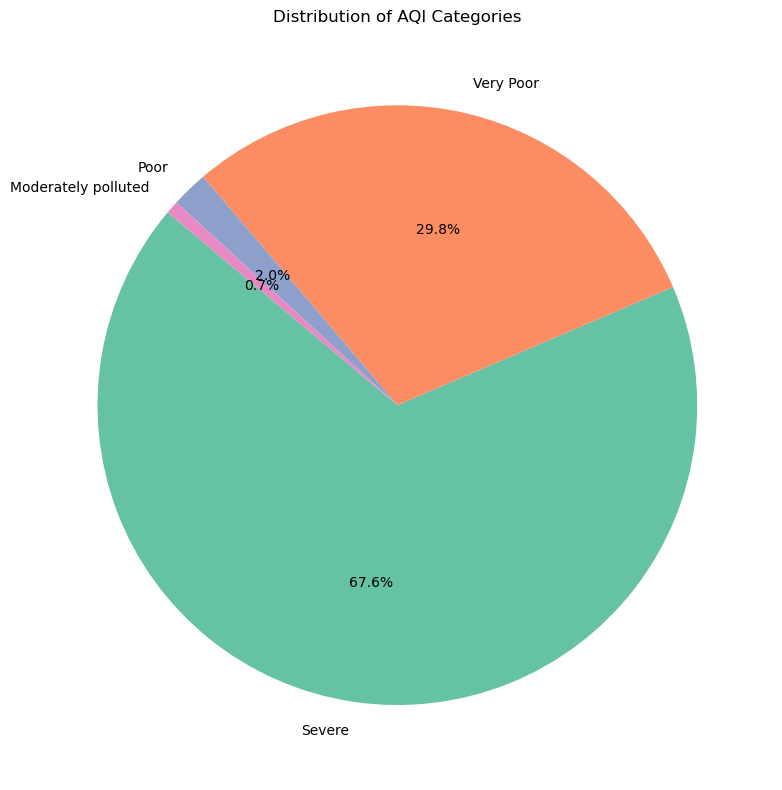

In [42]:
category_counts = data['AQI_Category'].value_counts()

plt.figure(figsize=(12,8))
plt.pie(category_counts, labels=category_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of AQI Categories')
plt.tight_layout()
sns.set_palette('Set2')
plt.show()

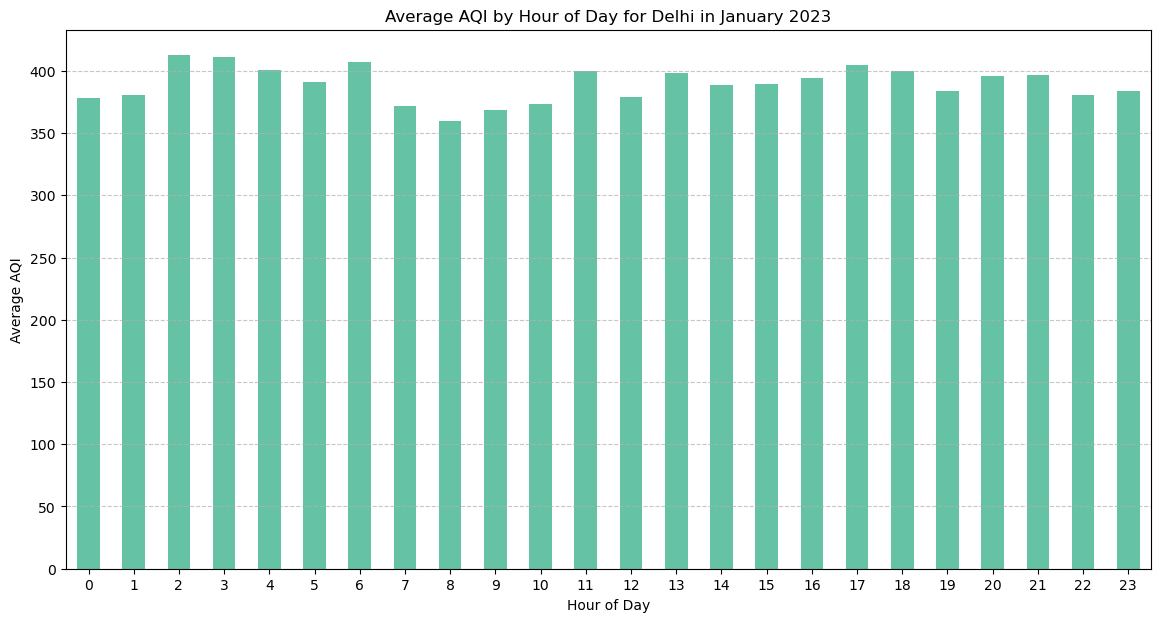

In [17]:
plt.figure(figsize=(14, 7))
hourly_aqi.plot(kind='bar')
plt.title('Average AQI by Hour of Day for Delhi in January 2023')
plt.xlabel('Hour of Day')
plt.ylabel('Average AQI')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
sns.set_palette('Set2')
plt.show()

In [18]:
day_hours = (6,18)
night_hours = (18,6)

daytime_data = data[(data['hour'] >= day_hours[0]) & (data['hour'] < day_hours[1])]
nighttime_data = data[(data['hour'] >= night_hours[0]) | (data['hour'] < night_hours[1])]

average_day_aqi = daytime_data['AQI'].mean()
average_night_aqi = nighttime_data['AQI'].mean()
day_night_aqi_comparison = pd.DataFrame({
    'Period': ['Day', 'Night'],
    'Average AQI': [average_day_aqi, average_night_aqi]
})


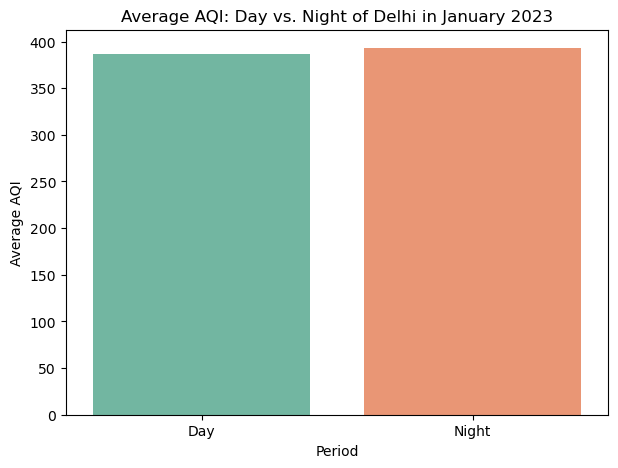

In [24]:
plt.figure(figsize=(7, 5))
sns.barplot(x='Period', y='Average AQI', data=day_night_aqi_comparison)
plt.title('Average AQI: Day vs. Night of Delhi in January 2023')
plt.ylabel('Average AQI')
sns.set_palette('Set2')
plt.show()


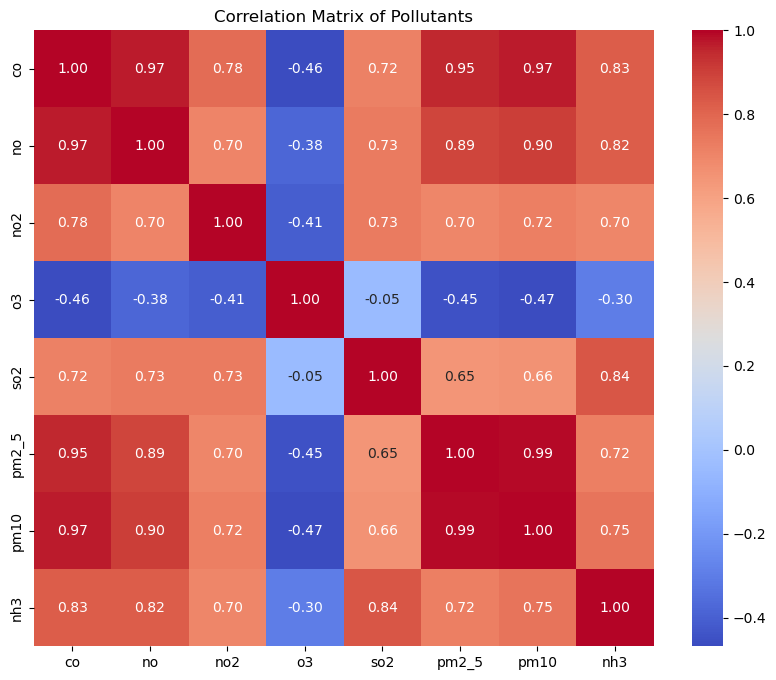

In [28]:
pollutants = ['co', 'no', 'no2', 'o3', 'so2', 'pm2_5', 'pm10', 'nh3']
correlation_matrix = data[pollutants].corr()

plt.figure(figsize=(10, 8))
plt.title('Correlation Matrix of Pollutants')
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", cbar=True)
plt.show()

## Findings

### Air Quality Levels:
####  "Very Poor" and "Severe" categories: 97.33% of the time
####  "Good" and "Satisfactory" categories: 2.67% of the time

### Hourly Trends:
####  Average AQI at night: 393.01
####  Average AQI during the day: 386.26

### Daily Extremes:
####  Highest daily AQI: 421.63
####  Lowest daily AQI: 330.37

### Pollutant Relationships:
####  Strong correlations found between certain pollutants, indicating shared  sources or similar dispersion patterns. 
